A notebook to calculate data for the Bayesian bot (analogous to training for ML bots)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from operator import itemgetter
from copy import deepcopy
import json

import draftsimtools as ds

In [3]:
# Load M19 drafts
raw_drafts = ds.load_drafts("../../data/m19_2.csv")

In [4]:
# Here other folks load card lists, but I grab them from json instead
# m19_set = ds.create_set("data/m19_rating.tsv", "data/m19_land_rating.tsv")
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON['M19']['cards']
thisSet = {card['name'] : card for card in jsonSubset}

In [5]:
# Create a list of names + lots of other useful stuff
nameList = pd.DataFrame.from_dict(thisSet, orient='index', columns=['colors','rarity','type','convertedManaCost'])
nameList['Name'] = nameList.index                 # We need names as a column, not an index
nameList['index'] = range(len(nameList))
nameList = nameList.set_index('index')     # And we need a normal numerical index
nameList[1:5]

,colors,rarity,type,convertedManaCost,Name
index,,,,,
1,[R],common,Sorcery,3.0,Act of Treason
2,[W],uncommon,Instant,2.0,Aegis of the Heavens
3,"[U, W]",uncommon,Creature — Human Artificer,4.0,Aerial Engineer
4,[U],uncommon,Enchantment — Aura,2.0,Aether Tunnel


In [6]:
# Process names, then handle weird card names (those with commas)
nameList['Name'] = nameList.Name.str.replace(' ','_')

# This utility method searches for "Name" column in nameList that have commas
nameList, raw_drafts = ds.fix_commas(nameList, raw_drafts) # Returns a tuple, as it updates both
# nameList.Name[nameList.Name.str.find(',')!=-1] # There should be no longer any cards with commas

In [7]:
# Process the drafts, deconstructing packs (hands) at every turn of every draft
drafts = ds.process_drafts(raw_drafts)

Processing draft: 0.
Processing draft: 10000.
Processing draft: 20000.
Processing draft: 30000.
Processing draft: 40000.
Processing draft: 50000.
Processing draft: 60000.
Processing draft: 70000.
Processing draft: 80000.
Processing draft: 90000.
Processing draft: 100000.


### Make sure all cards are listed, even weird foils

In [8]:
# Make sure all cards are listed in the nameList; update if necessary
for iDraft in range(200): #range(len(subset_drafts)):
    if iDraft>0 and iDraft % 100 == 0:
        print("Draft #%d" % iDraft)
    draft = drafts[iDraft]
    for pack in draft[1:100]: # Let's assume that first 100 drafts cover all the bases     
        for cardName in pack:
            try:
                pos = nameList[nameList.Name==cardName].index[0]
            except:
                print("---Unrecognized card: ",cardName) # All unrecognized cards here seem to be foil lands
                #  	colors 	rarity 	type 	convertedManaCost 	Name
                nameList = nameList.append({'colors':[],'rarity':'weird','type':'weird',
                                            'convertedManaCost':0,'Name':cardName},ignore_index=True)

---Unrecognized card:  Mountain_4
---Unrecognized card:  Forest_4
---Unrecognized card:  Plains_2
---Unrecognized card:  Mountain_2
---Unrecognized card:  Island_1
---Unrecognized card:  Forest_2
---Unrecognized card:  Swamp_1
---Unrecognized card:  Mountain_3
---Unrecognized card:  Forest_1
---Unrecognized card:  Island_4
---Unrecognized card:  Swamp_3
---Unrecognized card:  Plains_1
---Unrecognized card:  Swamp_4
---Unrecognized card:  Plains_4
---Unrecognized card:  Forest_3
---Unrecognized card:  Island_3
---Unrecognized card:  Swamp_2
---Unrecognized card:  Plains_3
---Unrecognized card:  Mountain_1
---Unrecognized card:  Island_2
Draft #100


### Calculate all the stats

In [27]:
nCardsInSet = len(nameList)
pCoDraft = np.zeros([nCardsInSet,nCardsInSet]) # Symmetric co-draft matrix
pChoice = np.zeros([nCardsInSet,nCardsInSet]) # Symmetric choice matrix
pFull = np.zeros(nCardsInSet) # Total number of times each card was drafted

In [28]:
# Main loop (very slow, unfortunately: 17 min for 5000 drafts)

nDrafts = 5000  # <----- Replace 100 with len(drafts) to run on the full dataset (107950)
tic = time.time()
for iDraft in range(nDrafts): #range(len(drafts)):
    if iDraft % 1000 == 0:
        print()
        print("Draft #%d/%d" % (iDraft,nDrafts), end = '')
    if iDraft % 100 == 0:
        print('.', end = '')
    draft = drafts[iDraft]
    collection = np.zeros(nCardsInSet)
    for pack in draft:     
        packVector = np.zeros(nCardsInSet)
        for cardName in pack:            
            pos = nameList[nameList.Name==cardName].index[0]            
            packVector[pos] += 1  # Mark the card
            if cardName==pack[0]: # If the first card in the pack, note it, as the Human picked it
                humanCard = pos

        humanPick = np.zeros(nCardsInSet)
        humanPick[humanCard] = 1
        # Preference matrix. A_ij counts how many times card i won over card j:
        pChoice += np.outer(humanPick,packVector)
        # Co-draft matrix, asymmetric. A_ij counts how many times i was drafted, with j already in collection:
        pCoDraft += np.outer(humanPick,collection)
        
        collection[humanCard] += 1 # Update collection
                
        #print(iDraft,iCard,nameList.iloc[humanCard]['Name'],nameList.iloc[humanCard]['colors'],
        #                   nameList.iloc[botCard]['Name'],  nameList.iloc[botCard]['colors'])
        
    # -- Out of drafting: Final collection
    # Symmetric variant of co-draft matrix (assumed to be inferior)
    # A_ij counts how many times cards i and j were co-drafted (symmetric matrix)
    # pCoDraft += np.outer(collection,collection)-np.diag(collection) # Diagonal: n^2-n = n(n-1)
    
    pFull += collection
    
# -- Out of loop: Final adjustments to everything
pCoDraft[range(nCardsInSet),range(nCardsInSet)] = pCoDraft[range(nCardsInSet),range(nCardsInSet)]/2 
# Scale diagonal by 0.5, to get n(n-1)/2
np.fill_diagonal(pChoice,0) # Weird method that modifies its argument instead of returning something
print('Done. Time elapsed (minutes): %5.1f' % (float(time.time() - tic)/60))


Draft #0/5000..........
Draft #1000/5000..........
Draft #2000/5000..........
Draft #3000/5000..........
Draft #4000/5000..........Done. Time elapsed (minutes):  17.0


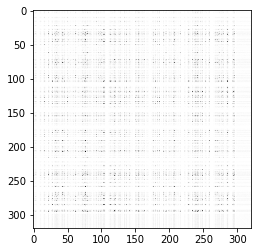

In [29]:
plt.imshow(pCoDraft, cmap="Greys");

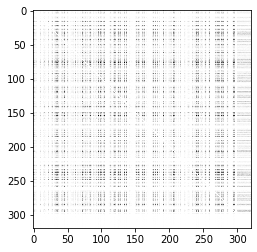

In [30]:
plt.imshow(pChoice, cmap="Greys");

In [31]:
pFull

array([1170., 1656.,  368.,  747.,  501.,  326.,    0.,    0.,    0.,
        126.,  468.,  874.,  134.,    0.,  458.,  338., 1225., 1868.,
        251.,  229.,  297.,    0., 1469., 1354.,  252.,    0.,  334.,
        356., 1342., 1504.,  108., 1053.,  619., 1324., 1762., 1507.,
        932.,  873.,  546., 1429.,  144.,  755.,  218., 1710.,  559.,
          0., 1781.,  236., 1935.,  162., 1369.,  160.,  443.,  255.,
        225.,  490.,  236.,  322.,  397.,  720.,  161., 1446., 1501.,
        232., 1622.,  333.,  768.,  503.,  324.,  420., 1280.,  559.,
       1916.,  773.,  969., 1064.,  145., 2183.,  736., 1022., 1504.,
        448.,  799.,  350., 1009.,  363., 1179.,    0.,  840.,  832.,
        468.,  487., 1279., 1221.,  198., 1179., 1534.,  513.,  367.,
       1369., 1183.,  645.,  551., 1448., 1759.,  102.,  202.,    0.,
        453.,    0.,  170., 2298.,  512., 1395.,  535.,  550.,  449.,
       1978.,  770., 2213.,  713., 1282.,  213., 2090.,  306., 1255.,
       1111., 1191.,

In [32]:
np.savetxt('bots_data/bayes_pCoDraft.csv', pCoDraft, delimiter=",")
np.savetxt('bots_data/bayes_pChoice.csv', pChoice, delimiter=",")
np.savetxt('bots_data/bayes_pFull.csv', pFull, delimiter=",")
# Save card names, to match later
pd.DataFrame(nameList['Name']).to_csv('bots_data/bayes_names.csv',index=False)

In [33]:
# Let's make sure that the preference matrix (pChoice) makes sense
rating = np.divide(sum(pChoice),1+sum(pChoice)+np.sum(pChoice,axis=1))
rating = np.argsort(rating)
nameList.iloc[rating[:10]] # 10 most preferred cards
#nameList.iloc[rating[-10:]] # 10 least preferred cards

,colors,rarity,type,convertedManaCost,Name
45,[W],uncommon,Creature — Human Cleric,1.0,Court_Cleric
208,[U],rare,Creature — Sphinx,6.0,Riddlemaster_Sphinx
250,[W],common,Creature — Human Soldier,2.0,Sun_Sentinel
291,[G],uncommon,Creature — Cat Spirit,3.0,Vivien's_Jaguar
197,[R],common,Instant,4.0,Radiating_Lightning
190,[],common,Basic Land — Plains,0.0,Plains
260,[B],common,Creature — Zombie Jackal,2.0,Tattered_Mummy
289,[G],mythic,Legendary Planeswalker — Vivien,6.0,Vivien_of_the_Arkbow
172,"[B, R, U]",mythic,Legendary Planeswalker — Bolas,4.0,Nicol_Bolas_the_Arisen
171,[U],mythic,Instant,7.0,Nexus_of_Fate


In [ ]:
# Playground for co-occurrence matrix
a = np.array([0,1,0,0,2,1,3])
b = np.outer(a,a)-np.diag(a)
# b = b*(np.ones(7)-np.eye(7)) + np.diag(np.diag(b)/2) # Horrible way
b[range(7),range(7)] = b[range(7),range(7)]/2 # Scale diagonal by 0.5
b

In [ ]:
# Playground for preference matrix
a = np.array([0,1,0,1,2]) # pack
b = 1 # Card that was taken (with zero indexing)
c = np.zeros(5)
c[b] = 1
np.outer(c,a)-np.diag(c)
# A_ij counts how many time card i won over card j